In [180]:
import torch
from spikingjelly.activation_based import neuron, base, surrogate
import matplotlib.pyplot as plt
from typing import Callable, Optional
import os, pandas as pd
import torch.nn.functional as F
import torch.nn as nn

In [181]:
src_file_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/065_SMD_id_9_Facility_tr_737_1st_837.csv'
#src_file_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/173_GECCO_id_1_Sensor_tr_16165_1st_16265.csv'

window_size = 50
start_idx = 817

df = pd.read_csv(src_file_path)
uts_data = df.iloc[start_idx:start_idx+window_size, 0].values
uts_data = torch.tensor(uts_data, dtype=torch.float32)
uts_data = uts_data.unsqueeze(0).unsqueeze(0) # (1, 1, 200)=(B, C, L)

mts_data = df.iloc[start_idx:start_idx+window_size, :-1].values # exclude the label column
mts_data = torch.tensor(mts_data, dtype=torch.float32)
mts_data = mts_data.unsqueeze(0)  # (1, 3, 200)=(B, C, L)

In [182]:
print(mts_data.shape)

torch.Size([1, 50, 38])


In [ ]:
class TCA(nn.Module):
    def __init__(self, num_features, window_size, reduction_ratio=0.5):
        super().__init__()

        self.ap = nn.AdaptiveAvgPool1d(1)
        self.mp = nn.AdaptiveMaxPool1d(1)

        print(f"window_size: {window_size}, reduction_ratio: {reduction_ratio}")

        self.fc1_t = nn.Linear(window_size, int(window_size * reduction_ratio))
        self.fc2_t = nn.Linear(int(window_size * reduction_ratio), window_size)

        self.fc1_c = nn.Linear(num_features, int(num_features * reduction_ratio))
        self.fc2_c = nn.Linear(int(num_features * reduction_ratio), num_features)

        self.relu = nn.ReLU(inplace=True)

    def temporal_attention(self, x):
        # x: (B, L, C)
        print(f"Input shape: {x.shape}")
        x_avg = self.ap(x) # (B, L, 1) <- (B, L, C)
        x_max = self.mp(x) # (B, L, 1) <- (B, L, C)

        x_avg = self.fc1_t(x_avg.squeeze(-1))  # (B, L, C//reduction_ratio)
        x_max = self.fc1_t(x_max.squeeze(-1))
        
        x_avg = self.relu(x_avg)
        x_max = self.relu(x_max)
        
        x_avg = self.fc2_t(x_avg)
        x_max = self.fc2_t(x_max)

        x = x_avg + x_max  # (B, L)
        return x.unsqueeze(1) # (B, 1, L)

    def channel_attention(self, x):
        # x: (B, C, L)
        x = x.permute(0, 2, 1)
        print(f"Input shape: {x.shape}")

        x_avg = self.ap(x) # (B, C, 1)
        #x_max = self.mp(x)

        x_avg = self.fc1_c(x_avg.squeeze(-1))  # (B, L, C//reduction_ratio)
        #x_max = self.fc1(x_max)
        print(x_avg.shape)
        
        x_avg = self.relu(x_avg)
        #x_max = self.relu(x_max)
        
        x_avg = self.fc2_c(x_avg)
        #x_max = self.fc2(x_max)

        x = x_avg
        return x.unsqueeze(2)  # (B, C, 1)

In [184]:
tca = TCA(mts_data.shape[-1], window_size, 0.5)

window_size: 50, reduction_ratio: 0.5


In [185]:
x_c = tca.channel_attention(mts_data)
x_t = F.sigmoid(tca.temporal_attention(mts_data))
print(f"Channel attention output shape: {x_c.shape}")
print(f"Temporal attention output shape: {x_t.shape}")

Input shape: torch.Size([1, 38, 50])
torch.Size([1, 19])
Input shape: torch.Size([1, 50, 38])
Channel attention output shape: torch.Size([1, 38, 1])
Temporal attention output shape: torch.Size([1, 1, 50])


In [186]:
attention = F.sigmoid(x_c * x_t)
print(f"Attention output shape: {attention.shape}")

Attention output shape: torch.Size([1, 38, 50])


In [187]:
attention_output = mts_data.permute(0, 2, 1) * attention

In [188]:
mts_data = mts_data.permute(0, 2, 1)

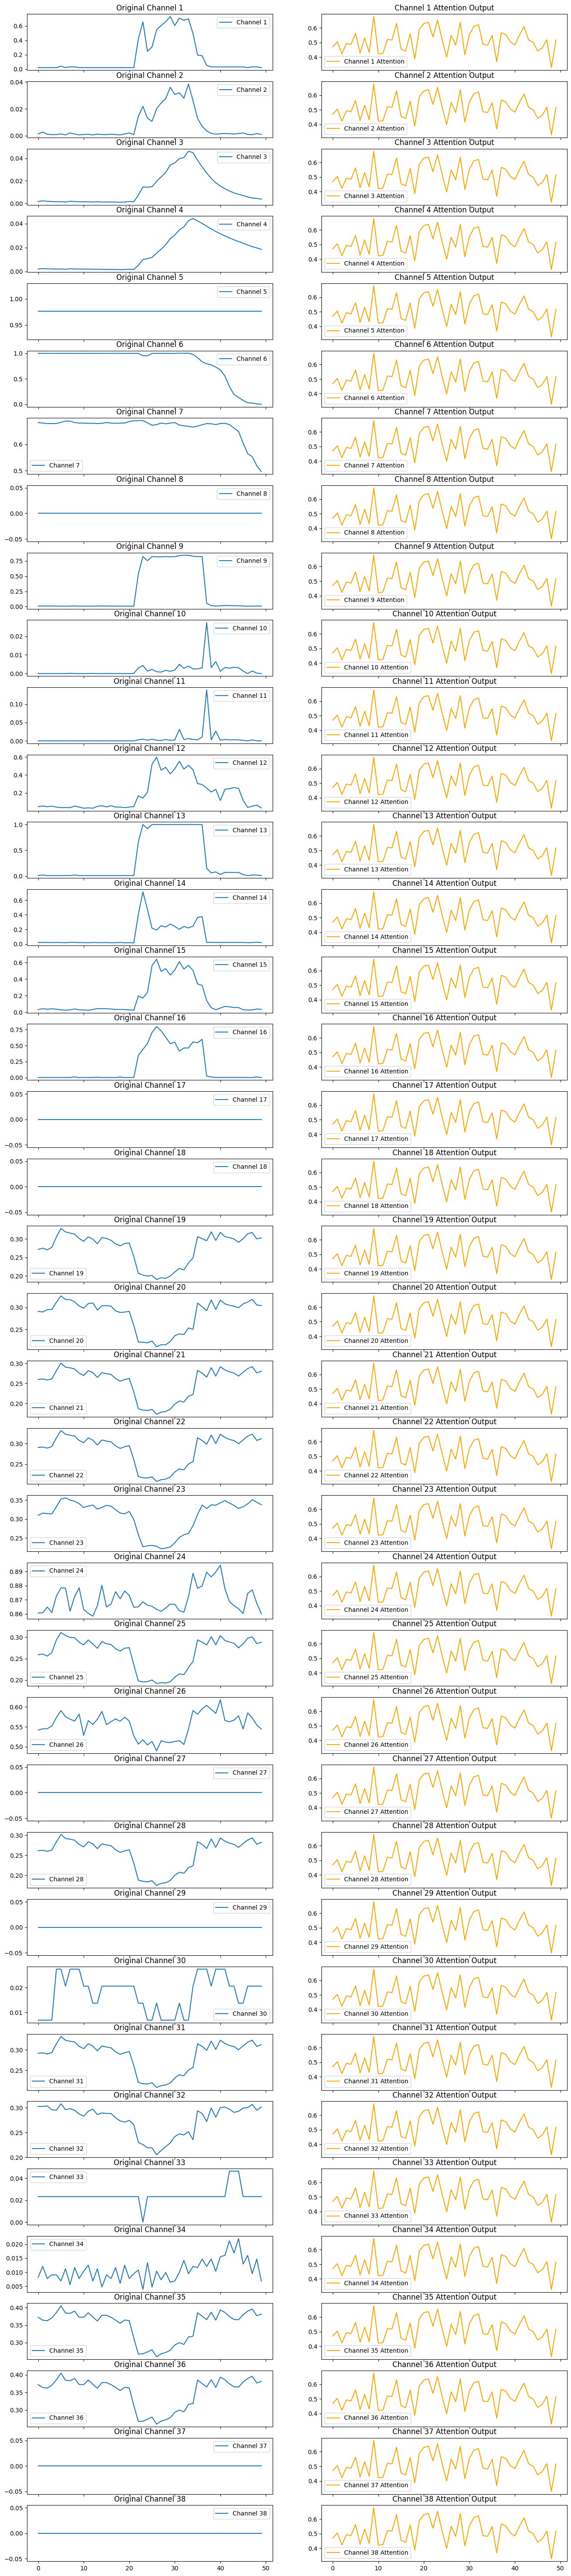

In [189]:
fig, axes = plt.subplots(mts_data.shape[1], 2, figsize=(16, 2 * mts_data.shape[1]), sharex=True)
for i in range(mts_data.shape[1]):
    axes[i, 0].plot(mts_data[0, i].numpy(), label=f'Channel {i+1}')
    axes[i, 0].set_title(f'Original Channel {i+1}')
    axes[i, 0].legend()

    axes[i, 1].plot(x_t[0, 0].detach().numpy(), label=f'Channel {i+1} Attention', color='orange')
    axes[i, 1].set_title(f'Channel {i+1} Attention Output')
    axes[i, 1].legend()